# Applying Kmeans Algorithms on NBA Player Play Type Stats

Ting Pan, github ID: [tingpan](https://github.com/tingpan)

In the previous [project](http://dota666.com/basketball/), we just did a very simple statistics and visualization, which is not insightful and interesting. I think we could apply some unsupervised clustering analysis (such as K-Means Clustering) with Shogun API on the dataset to classify the player into different type. 

This notebook shows clustering NBA Play Type Stats with KMeans in Shogun. Since I do not know how many types of players are there, I will use K-means and Elbow Method to find out the most suitable value of k.

First I will load the dataset. `play_freq.data` contains NBA Season 2015-16 play type stats from [stats.nba.com](http://stats.nba.com/). This comma-separated file contains 11 columns, which first column is player names and last 10 are frequence of 10 play types(Transition, Isolation, Pick & Roll, Pick & Roll: Roll Man, Post-Up, Spot-Up, Hand-Off, Cut, Off Screen and Rebound). I will load data from file and build features for training.

In [1]:
from numpy import array
def load_data():
    f = open('./play_freq.data')
    features = []
    names = []
    for line in f:
        words = line.rstrip().split(',')
        # Store player names
        names.append(words[0])
        # Store features of each player
        features.append([float(i) for i in words[1:]])

    f.close()

    return (array(features).T, names)
data, names = load_data()

This data object contains play types frequency of nearly 400 players. After obtained features of dataset, I will define the KMeans training method with Shogun Python API. I will use KMeans++ to make sure final centers mostly correspond to the global minima.

In [2]:
from modshogun import *
def train_kmeans(k, data):
    train_features = RealFeatures(data)
    # calculate euclidean distance of features
    distance = EuclideanDistance(train_features, train_features)

    # initialize KMeans++ object
    kmeans = KMeans(k, distance, True)

    # training kmeans
    kmeans.train(train_features)

    # labels for data points
    result = kmeans.apply()
    centers = kmeans.get_cluster_centers()
    radiuses = kmeans.get_radiuses()
    return result, centers, radiuses

Now I can train the dataset with specifying the number of clusters(k)

In [3]:
# Specifying the number of clusters(k)
# However, the actual amount of types is unknown
k = 8
result, centers, radiuses = train_kmeans(k, data)

Since I don't know the total amount of types, I will use Elbow Method to find out the most suitable value of k (i.e. type amount). I will run k-means clustering on the dataset with an increasing k. For each k, I will calculate the loss. The best k would be the k with a small loss and the trend of loss decreasing is diminishing.

I will run KMeans clustering on the dataset for a range of values of k, and for each value of k calculate the sum of radiuses. To ensure the final centers mostly correspond to the global minima, for each value of k I will train the dataset 10 times(As this is a demo, to increase speed of the notebook, I will only train 10 times.)

In [4]:
ys = []
xs = []
for k in range(5, 50):
    xs.append(k)
    _ys = []
    for i in range(1, 11):
        result, centers, radiuses = train_kmeans(k, data)
        _ys.append(sum(radiuses)/k)
    ys.append(sum(_ys)/10)

Then, I will plot a line chart of the average radiuses for each value of k; If the line chart looks like an arm, then the "elbow" on the arm is the value of k that is the best.

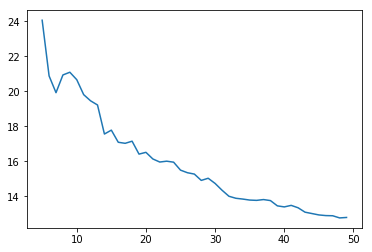

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(xs,ys)
plt.show()

As shown in figure, the best value of k is 25. After finding the best value of k, I will train the dataset to get all players types.

In [ ]:
k = 25
result, centers, radiuses = train_kmeans(k, data)

In the next step of this project, I will apply Decision Tree Learning (C4.5) to train a model for classifying new players.